In [ ]:
!pip install tensorflow

In [ ]:
import os
import time
import numpy as np
import math
from glob import glob
from ntpath import basename
from os.path import join, exists
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import Input, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from sklearn.model_selection import train_test_split
from scipy import ndimage
import gc
from google.colab import drive
import tensorflow as tf
from tensorflow.keras.layers import UpSampling2D


In [ ]:
# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:

# Utility functions

def deprocess(x):
    return (x + 1.0) * 0.5

def deprocess_uint8(x):
    im = ((x + 1.0) * 127.5)
    return np.uint8(im)

def preprocess(x):
    return (x / 127.5) - 1.0

def getPaths(data_dir):
    exts = ['*.png', '*.PNG', '*.jpg', '*.JPG', '*.JPEG']
    image_paths = []
    for pattern in exts:
        for d, s, fList in os.walk(data_dir):
            for filename in fList:
                if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
                    fname_ = os.path.join(d, filename)
                    image_paths.append(fname_)
    return np.asarray(image_paths)

def read_and_resize(path, res=(480, 640)):
    with Image.open(path) as img:
        img = img.resize(res, Image.BILINEAR)
        return np.array(img)

# Main code

# input and output data shape
hr_w, hr_h = 640, 360  # HR
lr_w, lr_h = 640, 360
lr_res, lr_shape = (lr_w, lr_h), (lr_h, lr_w, 3)
hr_res, hr_shape = (hr_w, hr_h), (hr_h, lr_w, 3)

def load_and_preprocess_data(data_dir, num_samples=None):
    lrd_dir = join(data_dir, "lrd")
    hr_dir = join(data_dir, "hr")

    lrd_paths = getPaths(lrd_dir)
    hr_paths = getPaths(hr_dir)

    if num_samples:
        lrd_paths = lrd_paths[:num_samples]
        hr_paths = hr_paths[:num_samples]

    lrd_images, hr_images = [], []
    for lrd_path, hr_path in zip(lrd_paths, hr_paths):
        lrd_img = read_and_resize(lrd_path, res=(lr_w, lr_h))
        hr_img = read_and_resize(hr_path, res=(hr_w, hr_h))

        lrd_images.append(preprocess(lrd_img))
        hr_images.append(preprocess(hr_img))

    return np.array(lrd_images), np.array(hr_images)

def create_sr_model(original_model, lr_shape):
    new_input = Input(shape=lr_shape)

    # Enhancement layers
    x = Conv2D(64, kernel_size=3, padding='same', activation='relu', name='enhance_conv1')(new_input)
    x = Conv2D(64, kernel_size=3, padding='same', activation='relu', name='enhance_conv2')(x)
    enhanced = Conv2D(3, kernel_size=3, padding='same', activation='tanh', name='enhanced_output')(x)

    # Super-resolution layers
    x = enhanced
    for i, layer in enumerate(original_model.layers[1:]):
        if isinstance(layer, Model):  # Skip any nested models
            continue
        if 'input' in layer.name:  # Skip input layers
            continue
        try:
            if isinstance(layer, UpSampling2D):
                x = UpSampling2D(size=(2, 2), name=f'upsampling_{i}')(x)
            elif 'conv2d' in layer.name:
                # Create a new layer with a unique name
                new_layer = Conv2D(
                    filters=layer.filters,
                    kernel_size=layer.kernel_size,
                    strides=layer.strides,
                    padding=layer.padding,
                    activation=layer.activation,
                    name=f'sr_conv_{i}'
                )
                x = new_layer(x)
            else:
                x = layer(x)
        except ValueError as e:
            print(f"Skipping layer {layer.name} due to: {str(e)}")
            continue

    sr_output = Conv2D(3, kernel_size=3, padding='same', activation='tanh', name='sr_output')(x)

    return Model(inputs=new_input, outputs=[enhanced, sr_output])

# Function to visualize results
def visualize_results(input_image, enhanced_image, sr_image, original_image):
    plt.figure(figsize=(20, 5))
    plt.subplot(141)
    plt.title('Input Image')
    plt.imshow(deprocess(input_image))
    plt.axis('off')

    plt.subplot(142)
    plt.title('Enhanced Image')
    plt.imshow(deprocess(enhanced_image))
    plt.axis('off')

    plt.subplot(143)
    plt.title('SR Image')
    plt.imshow(deprocess(sr_image))
    plt.axis('off')

    plt.subplot(144)
    plt.title('Original HR Image')
    plt.imshow(deprocess(original_image))
    plt.axis('off')

    plt.tight_layout()
    plt.savefig('sample_result.png')
    plt.close()

# Dataset path
custom_path = "/content/drive/MyDrive/Data/Custom"
test_path = "/content/drive/MyDrive/Data/Test"

# Model path
model_path = "/content/drive/MyDrive/Data/Models"
ckpt_name = "deep_sesr_2x_1d"
model_h5 = join(model_path, ckpt_name + ".h5")
model_json = join(model_path, ckpt_name + ".json")

# Output path
output_path = "/content/drive/MyDrive/Data/Output"

# Load and preprocess data
x_train, y_train = load_and_preprocess_data(custom_path)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

# Create upscaled versions of y_train and y_val for super-resolution target
y_train_upscaled = np.array([np.array(Image.fromarray((y*255).astype(np.uint8)).resize((1280, 720))) for y in y_train]) / 255.0
y_val_upscaled = np.array([np.array(Image.fromarray((y*255).astype(np.uint8)).resize((1280, 720))) for y in y_val]) / 255.0


# Load model
assert (exists(model_h5) and exists(model_json))
with open(model_json, "r") as json_file:
    loaded_model_json = json_file.read()
original_model = model_from_json(loaded_model_json)
original_model.summary()
original_model.load_weights(model_h5)

# Create the new model
generator = create_sr_model(original_model, (lr_h, lr_w, 3))
print("\nModified model for 640x360 input/output with enhancement")

# Compile the model
generator.compile(optimizer=Adam(learning_rate=1e-4),
                  loss=['mse', 'mse'],
                  loss_weights=[0.5, 0.5])  # Adjust weights as needed

# Fine-tuning
epochs = 5
batch_size = 8
history = generator.fit(
    x_train, [y_train, y_train_upscaled],  # Use normal y_train for enhanced, upscaled for SR
    validation_data=(x_val, [y_val, y_val_upscaled]),
    epochs=epochs,
    batch_size=batch_size,
    verbose=1
)

print("Fine-tuning completed")

# Plotting training history
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(history.history['loss'], label='Total Loss')
plt.plot(history.history['val_loss'], label='Val Total Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Use the correct output layer names for the component losses
plt.plot(history.history['enhanced_output_loss'], label='Enhancement Loss')
plt.plot(history.history['sr_output_loss'], label='SR Loss')
plt.title('Component Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig(join(output_path, 'training_history.png'))
plt.close()

# create dir for output test data
samples_dir = join(output_path, "keras_out_Test")
if not exists(samples_dir):
    os.makedirs(samples_dir)

# for testing arbitrary local data
test_paths = getPaths(test_path)
print("{0} test images are loaded".format(len(test_paths)))

# testing loop
times = []
batch_size = 2  # Adjust based on your available memory
for i in range(0, len(test_paths), batch_size):
    batch_paths = test_paths[i:i+batch_size]

    for idx, img_path in enumerate(batch_paths):
        # prepare data
        img_name = basename(img_path).split('.')[0]
        img_lrd = read_and_resize(img_path, res=(lr_w, lr_h))
        im = np.expand_dims(preprocess(img_lrd), axis=0)

        # get output
        s = time.time()
        gen_enhanced, gen_hr = generator.predict(im)
        tot = time.time()-s
        times.append(tot)

        # process raw outputs
        gen_enhanced = deprocess(gen_enhanced)[0]
        gen_hr = deprocess(gen_hr)[0]

        # save generated images
        Image.fromarray(deprocess_uint8(img_lrd)).save(join(samples_dir, img_name+'_input.png'))
        Image.fromarray(deprocess_uint8(gen_enhanced)).save(join(samples_dir, img_name+'_enhanced.png'))
        Image.fromarray(deprocess_uint8(gen_hr)).save(join(samples_dir, img_name+'_SESR.png'))

        print(f"Processed: {img_path}")

        # Visualize the first test result
        if i == 0 and idx == 0:
            visualize_results(img_lrd, gen_enhanced, gen_hr, img_lrd)  # Using img_lrd as original for visualization

    # Clear some memory
    gc.collect()

# Print statistics
num_test = len(test_paths)
if (num_test == 0):
    print("\nFound no images for test")
else:
    print("\nTotal images: {0}".format(num_test))
    Ttime, Mtime = np.sum(times[1:]), np.mean(times[1:])
    print("Time taken: {0} sec at {1} fps".format(Ttime, 1./Mtime))
    print("\nSaved generated images in {0}\n".format(samples_dir))

# Save the fine-tuned model
fine_tuned_model_json = generator.to_json()
with open(join(model_path, "fine_tuned_model.json"), "w") as json_file:
    json_file.write(fine_tuned_model_json)
generator.save_weights(join(model_path, "fine_tuned_model.h5"))
print("Saved fine-tuned model to disk")

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 240, 320, 3)]        0         []                            
                                                                                                  
 conv2d_1 (Conv2D)           (None, 240, 320, 64)         1792      ['input_3[0][0]']             
                                                                                                  
 conv2d_2 (Conv2D)           (None, 240, 320, 64)         36928     ['conv2d_1[0][0]']            
                                                                                                  
 conv2d_3 (Conv2D)           (None, 240, 320, 64)         36928     ['conv2d_2[0][0]']            
                                                                                            

Processed: /content/drive/MyDrive/Data/Test/824.jpeg
1/1 [==============================] - 1s 1s/step
Processed: /content/drive/MyDrive/Data/Test/156.jpeg
1/1 [==============================] - 2s 2s/step
Processed: /content/drive/MyDrive/Data/Test/787.jpeg
1/1 [==============================] - 2s 2s/step
Processed: /content/drive/MyDrive/Data/Test/382.jpeg
1/1 [==============================] - 2s 2s/step
Processed: /content/drive/MyDrive/Data/Test/710.jpeg
1/1 [==============================] - 2s 2s/step
Processed: /content/drive/MyDrive/Data/Test/78.jpeg
1/1 [==============================] - 2s 2s/step
Processed: /content/drive/MyDrive/Data/Test/1747.jpeg
1/1 [==============================] - 2s 2s/step
Processed: /content/drive/MyDrive/Data/Test/626.jpeg
1/1 [==============================] - 2s 2s/step
Processed: /content/drive/MyDrive/Data/Test/146.jpeg
1/1 [==============================] - 2s 2s/step
Processed: /content/drive/MyDrive/Data/Test/824.jpeg
1/1 [===============

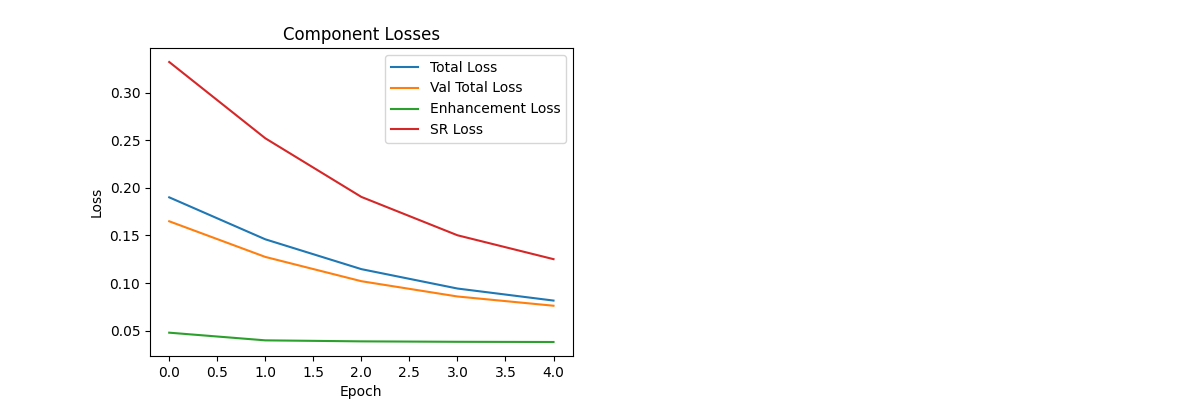

In [ ]:
from IPython.display import Image
Image(filename=join(output_path, 'training_history.png'))